In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import confusion_matrix

# 1. exploratory data analysis 

In [2]:
data = pd.read_csv("paysim1/PS_20174392719_1491204439457_log.csv")

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
len(data)

6362620

In [6]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [7]:
# check to see if any null value in the dataset
data.isnull().values.any()

False

In [8]:
data.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

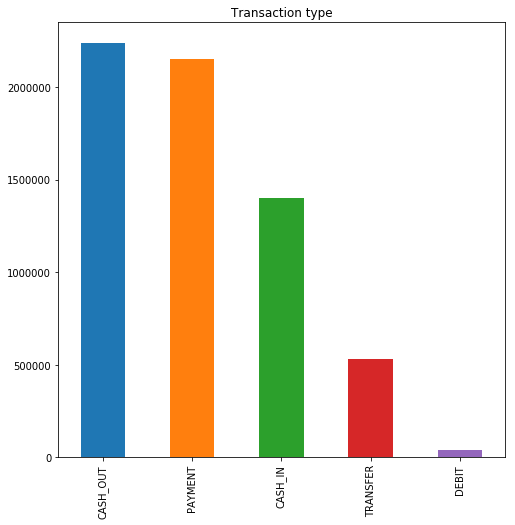

In [9]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
data.type.value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
plt.show()

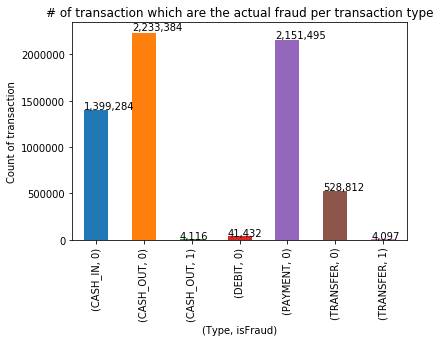

In [10]:
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

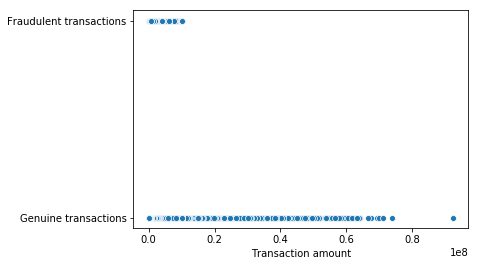

In [11]:
# Genuine trasactions have longer span of trasaction amount than fraudulent transactions
ax = sns.scatterplot(x="amount", y="isFraud", data=data)
y = np.arange(2)
plt.xlabel("Transaction amount")
plt.ylabel("")
plt.yticks(y, ("Genuine transactions", "Fraudulent transactions"))
plt.show()

In [12]:
# fraudulent transactions only appeared in TRANSFER and CASH_OUT tpyes
fraud_tra=data[data['isFraud']==1]
print (f"{fraud_tra.type.unique()}")
fraud_transfer=fraud_tra[fraud_tra.type=='TRANSFER']
fraud_cash_out=fraud_tra[fraud_tra.type=='CASH_OUT']
print (f"Numbers of total fraud trascactions: {len(fraud_tra)}.")
print (f"Numbers of fraud trascactions are TRANSFER: {len(fraud_transfer)}.")
print (f"Numbers of fraud trascactions are CASH_OUT: {len(fraud_cash_out)}.")

['TRANSFER' 'CASH_OUT']
Numbers of total fraud trascactions: 8213.
Numbers of fraud trascactions are TRANSFER: 4097.
Numbers of fraud trascactions are CASH_OUT: 4116.


In [13]:
# isFlaggedFraud flags illegal attempts to transfer more than 200.000 in a single transaction.
flag_fraud_tra=data[data['isFlaggedFraud']==1]
flag_fraud_tra.amount.min()

353874.22

In [14]:
# isFlaggedFraud is confusing. There are 5455 trasactions attempts to transfer more than 200,000, but not labbled flag.
# I will ignore the isFlaggedFraud column, cause all the trasactions in isFlaggedFraud are included in fraud trasactions.  
fraud_not_flag=fraud_tra[fraud_tra.isFlaggedFraud!=1]
len(fraud_not_flag[fraud_not_flag.amount>200000])

5455

In [15]:
print (f"Numbers of total fraud trascactions (not flag): {len(fraud_not_flag)}.")
fraud_transfer_not_flag=fraud_not_flag[fraud_not_flag.type=='TRANSFER']
fraud_cash_out_not_flag=fraud_not_flag[fraud_not_flag.type=='CASH_OUT']
print (f"Numbers of fraud trascactions (not flag) are TRANSFER: {len(fraud_transfer_not_flag)}.")
print (f"Numbers of fraud trascactions (not flag) are CASH_OUT: {len(fraud_cash_out_not_flag)}.")

Numbers of total fraud trascactions (not flag): 8197.
Numbers of fraud trascactions (not flag) are TRANSFER: 4081.
Numbers of fraud trascactions (not flag) are CASH_OUT: 4116.


In [16]:
## Are the fraud trascaction related to the orignial and destination account name? It turns out there is no relation.
fraud_tra['nameDest'].isin(fraud_tra['nameOrig']).any()

False

In [17]:
fraud_transfer.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.0,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.0,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.0,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,1,0


In [18]:
# Among all the fraud transfer transaction, 4068 of 4097 (99.3%) have zero balance in both oldbalanceDest and newbalanceDest columns
print (len(fraud_transfer))
print (len(fraud_transfer[fraud_transfer.oldbalanceDest==0]))
print (len(fraud_transfer[fraud_transfer.newbalanceDest==0]))
print (len(fraud_transfer[(fraud_transfer.oldbalanceDest==0) & (fraud_transfer.newbalanceDest==0)]))
print (len(fraud_transfer[(fraud_transfer.oldbalanceDest==0) & (fraud_transfer.newbalanceDest==0)])/len(fraud_transfer))

4097
4092
4068
4068
0.992921649987796


In [19]:
# Among all the non fraud transfer transaction, 106 of 528812 (0.02%) have zero balance in both oldbalanceDest and newbalanceDest columns
non_fraud_tra=data[data['isFraud'] == 0]
non_fraud_transfer=non_fraud_tra[non_fraud_tra.type=='TRANSFER']
print (len(non_fraud_transfer))
print (len(non_fraud_transfer[non_fraud_transfer.oldbalanceDest==0]))
print (len(non_fraud_transfer[non_fraud_transfer.newbalanceDest==0]))
print (len(non_fraud_transfer[(non_fraud_transfer.oldbalanceDest==0) & (non_fraud_transfer.newbalanceDest==0)]))
print (len(non_fraud_transfer[(non_fraud_transfer.oldbalanceDest==0) & (non_fraud_transfer.newbalanceDest==0)])/len(non_fraud_transfer))

528812
61041
1106
106
0.00020044930901719327


From the above data exploratory, we can see that nameOrig, nameDest, isFlaggedFraud columns are not related to fraud, we will delete this columns later. In the type column, fraud only occurs in "TRANSFER" and "CASH_OUT" types, thus we will select these two types for machine learning.

# 2. data cleaning

In [20]:
data_ml=data.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)

In [21]:
data_ml.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [22]:
data_ml_tran_cash=data_ml[(data_ml['type']=='TRANSFER')|(data_ml['type']=='CASH_OUT')]

In [23]:
# get dummy variable for the types
data_ml_dummy=pd.get_dummies(data_ml_tran_cash)

In [24]:
data_ml_dummy.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [25]:
X = data_ml_dummy.drop(['isFraud'],axis=1)
y = data_ml_dummy['isFraud']

In [26]:
# skip this step will lower the score to 0.9993286192296447
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

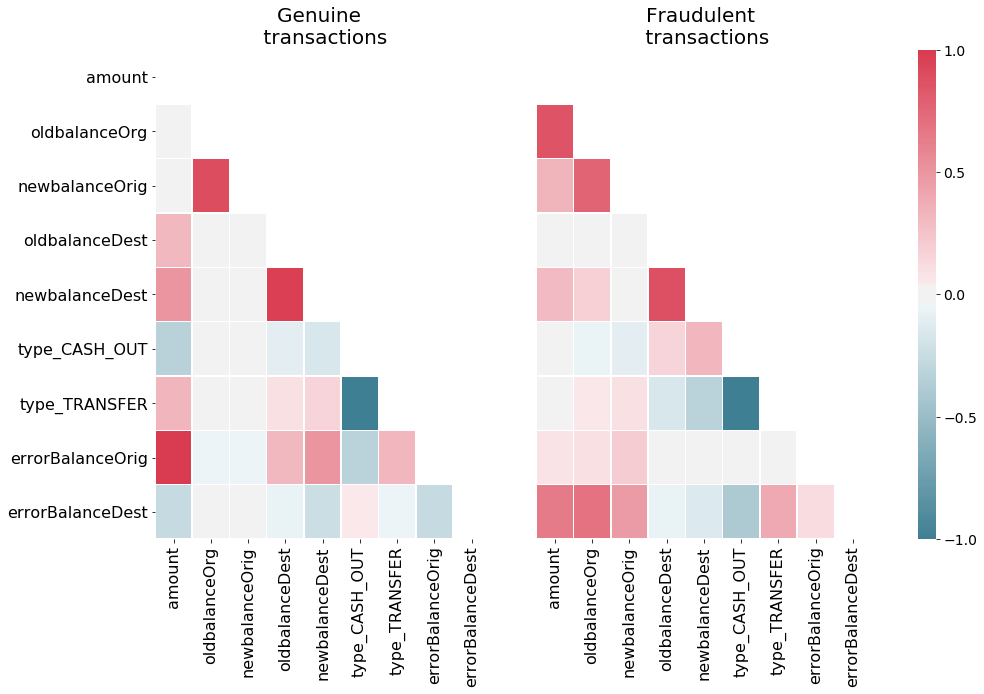

In [27]:
Xfraud = X.loc[y == 1] 
XnonFraud = X.loc[y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42)

C:\Users\gq_wh\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [29]:
# takes 30 min to run, score = 0.999980147342812
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.999980147342812

In [30]:
sort_import=pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns), reverse=True))

Text(0, 0.5, 'features')

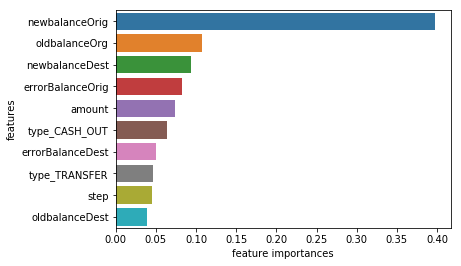

In [31]:
sns.barplot(x=sort_import[0], y=sort_import[1])
plt.xlabel("feature importances")
plt.ylabel("features")

In [32]:
# for tree visualization, set max_depth = 3
# takes 30 min to run, score = 0.998197017769933
rf_limited = RandomForestClassifier(max_depth = 3,n_estimators=200)
rf_limited = rf_limited.fit(X_train, y_train)
rf_limited.score(X_test, y_test)

0.9983829108326926

In [33]:
estimator = rf_limited.estimators_[5]
export_graphviz(estimator, out_file='fraud_tree.dot', feature_names = X_train.columns,
                class_names = ['Genuine','Fraudulent'], rounded = True, proportion = False, precision = 2, 
                filled = True)

In [ ]:
# use command line to run the code
# dot -Tpng fraud_tree.dot -o fraud_tree.png -Gdpi=600

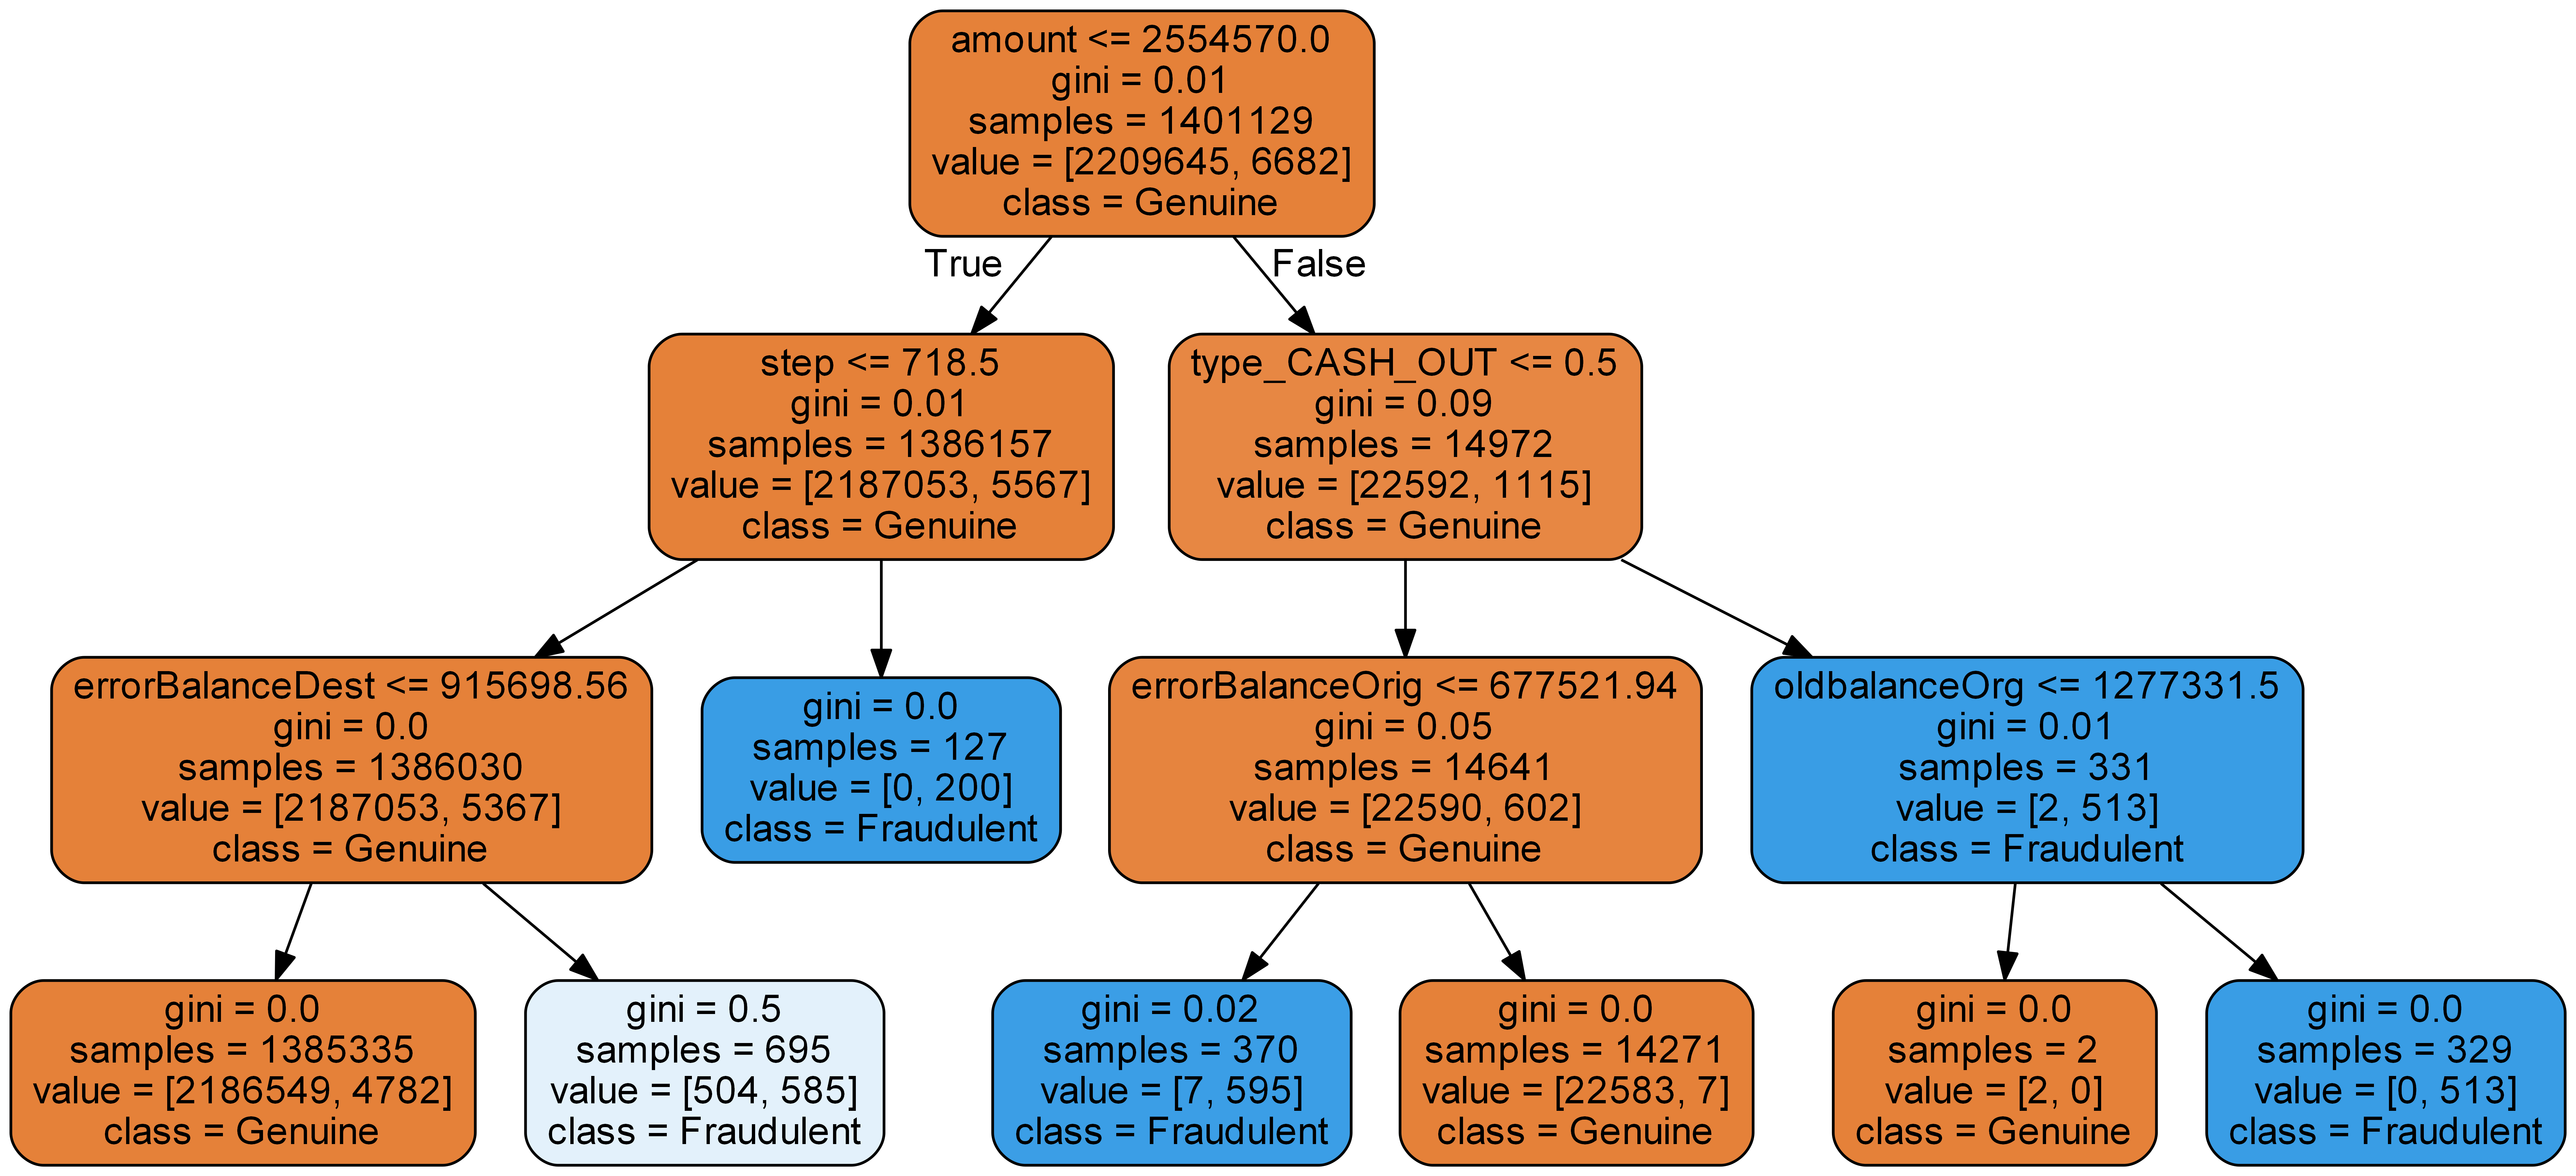

In [56]:
from IPython.display import Image
Image(filename = 'fraud_tree.png')

In [34]:
y_pred = rf.predict(X_test)

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

In [36]:
cnf_matrix

array([[552436,      0],
       [    11,   1635]], dtype=int64)

Text(26.499999999999996, 0.5, 'Actual')

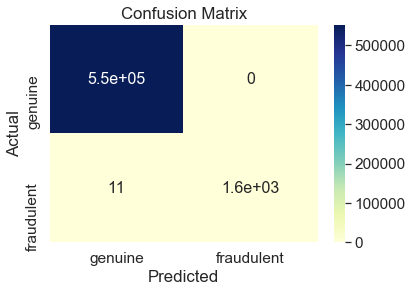

In [37]:
df_cm = pd.DataFrame(cnf_matrix, ["genuine","fraudulent"],
                  ["genuine","fraudulent"])
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")